## 8.2 RNN을 활용한 주가 방향성 분류 예측

* Applicationof Deep Learning to Algorithmic Trading(2017)
> LSTM을 활용한 다음날 수정 종가 예측, 가중치 감쇠 문제를 해결하는데 좋음

- 가중치감쇠?
> 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제하는 방법
> 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많음
https://ko.d2l.ai/chapter_deep-learning-basics/weight-decay.html
- 신경망에서 과대 과적합을 방지하기 위한 가중치 규제
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko

* 가격 데이터
> 시가, 고가, 저가, 수정종가, 거래량, 로그수익률
* 기술 지표 데이터
> 이동평균선, 이동표준 편차, 볼린저 밴드, ATR, 1개월 모멘텀, CCI, 3개월 모멘텀 변동 비율, MACD, 매수/매도 스트레스 측정
* 시장 데이터
> S&P 500 지수, 반도체 지수, 변동성 지수

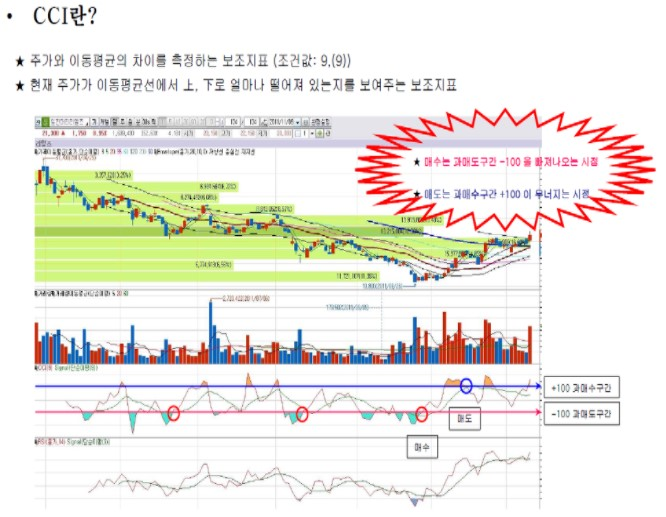

In [2]:
from IPython.display import Image
Image("CCI.jpg")

### 8.2.1 데이터

* 데이터 가공 5단계
> 1. Raw 데이터 불러오기
> 2. 데이터 가공 및 결합하기
> 3. 훈련, 검증, 테스트 데이터셋 분리하기
> 4. 학습에 용이하도록 데이터 정규화하기
> 5. 특성 데이터, 레이블 데이터 나누기

In [4]:
# pandas_datareader, talib 등등 필요 라이브러리 설치 해야함
import pandas as pd 
import pandas_datareader as pdr
import talib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import random as python_random

seed_number = 7
np.random.seed(seed_number)
python_random.seed(seed_number)
tf.random.set_seed(seed_number)

## DataLoad

In [7]:
# data Load
df = pd.read_csv('data/ch08/intc.csv', index_col='Date', parse_dates=True)
sox_df = pd.read_csv('data/ch08/sox_df.csv', index_col='Date', parse_dates=True)
vix_df = pd.read_csv('data/ch08/vix_df.csv', index_col='Date', parse_dates=True)
snp500_df = pd.read_csv('data/ch08/s&p500.csv', index_col='Date', parse_dates=True)

## Data Features
* 기술분석을 위한 지표 만들기

In [8]:
df['next_price'] = df['Adj Close'].shift(-1)
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA : Standard deviation rolling average
# Moving Average
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd 

# Momentum Indicators
#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
# Volatility Indicators 

#4.ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL : Bollinger Band
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1 
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [9]:
snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'},inplace=True)
sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'},inplace=True)
vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'},inplace=True)

df = df.join(snp500_df,how='left')
df = df.join(sox_df,how='left')
df = df.join(vix_df,how='left')

In [10]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_price,next_rtn,log_return,CCI,...,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,41.9375,40.96875,41.906250,41.15625,11572000.0,26.504349,28.013699,-0.017897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1469.250000,704.559998,24.639999
2000-01-03,43.6875,41.62500,41.632812,43.50000,57710200.0,28.013699,26.705585,0.044849,0.055385,NaN,...,NaN,NaN,NaN,2.34375,NaN,NaN,NaN,1455.219971,713.200012,24.209999
2000-01-04,43.9375,41.12500,42.718750,41.46875,51019600.0,26.705585,26.926966,-0.029261,-0.047821,NaN,...,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN,1399.420044,687.320007,27.010000
2000-01-05,42.9375,40.25000,41.500000,41.81250,52389000.0,26.926966,25.357227,0.007530,0.008255,NaN,...,NaN,NaN,NaN,0.34375,0.65625,NaN,NaN,1402.109985,678.539978,26.410000
2000-01-06,41.6875,39.09375,40.875000,39.37500,55171200.0,25.357227,26.403713,-0.036697,-0.060064,NaN,...,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN,1403.449951,669.330017,25.730000


In [11]:
# feature list
# feature_list = ['Adj Close', 'log_return', 'CCI','next_price']
# 볼린저 밴드와 MACD를 어떻게 활용해야할까? 음. 아님 그냥 그대로 사용하는 건가?
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['S&P500', 'SOX', 'VIX']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']

all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [12]:
phase_flag = '3'

if phase_flag == '1' :
    train_from = '2010-01-04'
    train_to = '2012-01-01'

    val_from = '2012-01-01'
    val_to = '2012-04-01'

    test_from = '2012-04-01'
    test_to = '2012-07-01'

elif phase_flag == '2' :
    train_from = '2012-07-01'
    train_to = '2014-07-01'

    val_from = '2014-07-01'
    val_to = '2014-10-01'

    test_from = '2014-10-01'
    test_to = '2015-01-01'
    
else : 
    train_from = '2015-01-01'
    train_to = '2017-01-01'

    val_from = '2017-01-01'
    val_to = '2017-04-01'

    test_from = '2017-04-01'
    test_to = '2017-07-01'

In [27]:
# train / validation / testing
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [28]:
train_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,31.625349,23605600.0,0.001927,0.360369,0.422398,37.964195,35.625804,...,36.828,36.961,0.070000,-0.820000,8.634596,-57.261459,2058.199951,686.729980,17.790001,-0.008454
2015-01-05,36.200001,36.450001,35.939999,31.268734,32785000.0,-0.011340,0.359143,0.416504,37.902114,35.536885,...,36.508,36.854,-0.410000,-0.809998,4.902248,-74.273902,2020.579956,673.590027,19.920000,-0.006906
2015-01-06,36.080002,36.230000,35.259998,30.685978,30847600.0,-0.018813,0.429746,0.417354,37.855069,35.344930,...,36.128,36.745,-0.670002,-1.010002,4.937537,-99.193531,2002.609985,658.830017,21.120001,-0.022173
2015-01-07,35.639999,36.070000,35.270000,31.329620,27725200.0,0.020758,0.449678,0.396641,37.788620,35.293380,...,35.980,36.626,0.740002,-0.340000,12.879977,-69.354794,2025.900024,665.270020,19.309999,0.010662
2015-01-08,36.369999,37.000000,36.259998,31.912374,31765400.0,0.018430,0.450896,0.396890,37.770449,35.291550,...,36.060,36.552,0.669998,0.739998,16.587224,-42.338775,2062.139893,684.650024,17.010000,0.008798


* 최소-최대 정규화

In [29]:
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # 스케일러 생성 및 훈련
        scaler = MinMaxScaler(feature_range=(0, 1)) # sklearn 라이브러리에서 정규화 객체를 받음
        scaler = scaler.fit(values)
        # print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # 데이터셋 정규화 및 출력
        normalized = scaler.transform(values) # 입력 데이터를 최소-최대 정규화
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized # 정규화된 데이터를 새로운 컬럼명으로 저장
    return sample_df, eng_list

In [30]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [31]:
train_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,31.625349,23605600.0,0.001927,0.360369,0.422398,37.964195,35.625804,...,0.611705,0.900729,0.926549,0.622449,0.408772,0.624169,0.427385,0.517622,0.335631,0.221242
2015-01-05,36.200001,36.450001,35.939999,31.268734,32785000.0,-0.011340,0.359143,0.416504,37.902114,35.536885,...,0.576726,0.872265,0.916140,0.524490,0.410527,0.552398,0.257261,0.432631,0.301055,0.293519
2015-01-06,36.080002,36.230000,35.259998,30.685978,30847600.0,-0.018813,0.429746,0.417354,37.855069,35.344930,...,0.526877,0.838463,0.905536,0.471428,0.375438,0.553077,0.008065,0.392034,0.262216,0.334238
2015-01-07,35.639999,36.070000,35.270000,31.329620,27725200.0,0.020758,0.449678,0.396641,37.788620,35.293380,...,0.511096,0.825298,0.893959,0.759184,0.492983,0.705804,0.306452,0.444650,0.279162,0.272820
2015-01-08,36.369999,37.000000,36.259998,31.912374,31765400.0,0.018430,0.450896,0.396890,37.770449,35.291550,...,0.519944,0.832414,0.886759,0.744898,0.682456,0.777092,0.576612,0.526523,0.330158,0.194774


* LSTM Model을 위한 학습데이터와 레이블데이터 나누기

In [32]:
num_step = 5
num_unit = 200

In [33]:
def create_dateset_binary(data, feature_list, step, n):

    train_xdata = np.array(data[feature_list[0:n]]) # LSTM 모델에 넣을 변수 데이터 선택
    m = np.arange(len(train_xdata) - step) # 마지막 단계 설정
    
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]  # 단계별 사용할 학습 데이터 기간 정의
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n)) # 신경망 학습에서 사용할 수 있게 데이터 정리
    
    train_ydata = np.array(data[[feature_list[n]]])  # 레이블링 데이터 생성 --> 다음날 종가
    
    for i in m + step :
        start_price = train_ydata[i-1][0]  # 이진 분류를 하기 위한 시작 종가 설정
        end_price = train_ydata[i][0] # 이진 분류를 하기 위한 종료 종가 설정
        
        if end_price > start_price :  # 오르면 1, 내리면 0 --> 이진 분류 레이블 생성
            label = 1
        else :
            label = 0
        y.append(label)  # 임시로 생성된 레이블 순차적 저장
    y_batch = np.reshape(np.array(y), (-1,1))  # 학습을 위한 1차원 열 벡터 형태 변경
    return x_batch, y_batch

In [34]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1

# 훈련 데이터에 대한 변수 데이터와 레이블 데이터를 나눔
x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
# 검증 데이터에 대한 변수 데이터 와 레이블 데이터를 나눔
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
# 테스트 데이터에 대한 변수 데이터와 레이블 데이터를 나눔
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

In [35]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [36]:
print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    259.0
1    240.0
dtype: float32
0    31.0
1    26.0
dtype: float32
0    28.0
1    30.0
dtype: float32


In [37]:
x_train.shape
# 1일씩 윈도우를 슬라이딩해서 499번 이동했음
# 1개의 시점에 22개 변수를 사용, 5일 데이터로 1 step 학습
# 5일이라는 타임라인에 걸친 22개의 변수를 사용해 다음날 종가를 예측하는 것

(499, 5, 22)

### 모델을 수정해보자 Keras로 

In [38]:
x_train.shape[1]
# 이것은 전체 데이터를 242 rolling , 10 window, 2개 feature를 본다는 것이다.
# 2개 feature를 10개 묶음으로 보는데, 1칸씩 미루면서 보니 242개 데이터를 본다는 것이다.

5

### 8.2.2 모델구조

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [40]:
# LSTM 모델을 생성한다.
K.clear_session()

# 입력 데이터셋 형태에 맞게 값을 지정, 1: 데이터갯수; 임의의 스칼라 NONE, 2: 데이터 시간 축, 3: LSTM 입력층에 한 번에 입력되는 데이터 개수(특성데이터)
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
# 다층 구조로 구성된 LSTM
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
# 배치정규화층 이어줌
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
# LSTM 각 층에 L2규제를 적용하며 계속 층을 이어감
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
# 드롭아웃을 이어 임의의 확률로 가중치 선을 지움
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
# LSTM층 -> BatchNomalize -> LSTM -> Dropout 반복하며 층을 쌓음
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)

# 완전 연결층으로 연결되면서 최종 예측값을 추출
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)

# 입력층과 출력층을 연결해 모델 객체를 만듬
model = Model(input_layer, output_layer)
# 모델 학습 방식을 설정해 모델 결정
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [41]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 200)            178400    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 200)            800       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
dropout (Dropout)            (None, 5, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 200)           

https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/
이 말인 즉슨 LSTM이 자체 gate 별 활성화 함수를 갖고있다.

In [42]:
y_val.shape

(57, 2)

### 8.2.3 모델 학습

In [43]:
history = model.fit(x_train,y_train,epochs=20, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/20
50/50 [==============================] - 4s 89ms/step - loss: 5.7333 - accuracy: 0.4669 - val_loss: 2.5351 - val_accuracy: 0.5439
Epoch 2/20
50/50 [==============================] - 2s 38ms/step - loss: 1.7090 - accuracy: 0.4870 - val_loss: 1.1354 - val_accuracy: 0.5439
Epoch 3/20
50/50 [==============================] - 2s 39ms/step - loss: 0.9748 - accuracy: 0.5150 - val_loss: 0.8309 - val_accuracy: 0.5439
Epoch 4/20
50/50 [==============================] - 2s 39ms/step - loss: 0.8024 - accuracy: 0.4409 - val_loss: 0.7398 - val_accuracy: 0.5439
Epoch 5/20
50/50 [==============================] - 2s 39ms/step - loss: 0.7360 - accuracy: 0.5050 - val_loss: 0.7130 - val_accuracy: 0.5439
Epoch 6/20
50/50 [==============================] - 2s 40ms/step - loss: 0.7291 - accuracy: 0.4629 - val_loss: 0.7031 - val_accuracy: 0.5263
Epoch 7/20
50/50 [==============================] - 2s 42ms/step - loss: 0.7188 - accuracy: 0.5030 - val_loss: 0.7082 - val_accuracy: 0.5439
Epoch 8/20
50

In [44]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

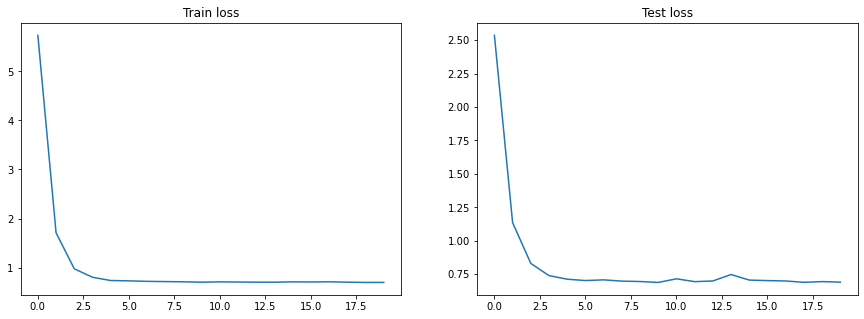

In [45]:
plot_history(history) # 3단계

In [46]:
# model.save('model_functional_open_close_binary_phase3.h5')

### 8.2.4 모델을 활용한 결과 예측

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [48]:
predicted = model.predict(x_test)  # 테스트 데이터로 모델의 예측값을 출력
y_pred = np.argmax(predicted, axis=1)  # 원-핫 인코딩으로 되어있는 예측값과 실제 레이블 데이터를 다른 범주로 바꿈
Y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred) # 사이킷런에서 제공하는 혼동 행렬 함수를 호출
report = classification_report(Y_test, y_pred)  # 혼동 행렬에서 계산된 수치를 바탕으로 더 많은 수치 계산을 연산하는 리포트 함수 호출

#### ROC AUC 커브
https://bioinformaticsandme.tistory.com/328

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

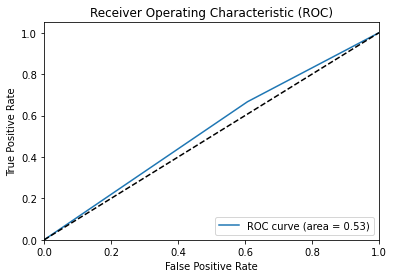

ROC AUC 값 : 0.5298


In [50]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

In [51]:
y_pred # 3단계

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [54]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)

#f_output = open('binary_lstm_open_close_phase3_dropout_batch_Normal_3단계 test.txt', 'a')
print('=======\n')
print('{}epochs_{}batch\n'.format(20, 10))
print('TN: {}\n'.format(tn))
print('FN: {}\n'.format(fn))
print('TP: {}\n'.format(tp))
print('FP: {}\n'.format(fp))
print('TPR: {}\n'.format(TPR))
print('FPR: {}\n'.format(FPR))
print('accuracy: {}\n'.format(accuracy))
print('specitivity: {}\n'.format(specitivity))
print("sensitivity : {}\n".format(sensitivity))
print("mcc : {}\n".format(mcc))
print("{}".format(report))
print('=======\n')
#f_output.write('=======\n')
#f_output.close()


20epochs_10batch

TN: 11

FN: 10

TP: 20

FP: 17

TPR: 0.6666666666666666

FPR: 0.6071428571428571

accuracy: 0.534

specitivity: 0.393

sensitivity : 0.667

mcc : 0.062

              precision    recall  f1-score   support

           0       0.52      0.39      0.45        28
           1       0.54      0.67      0.60        30

    accuracy                           0.53        58
   macro avg       0.53      0.53      0.52        58
weighted avg       0.53      0.53      0.53        58




In [55]:
# 예측.
# y_hat = model.predict(x_test, batch_size = 1)
print(len(y_test))
print(len(y_pred))

58
58


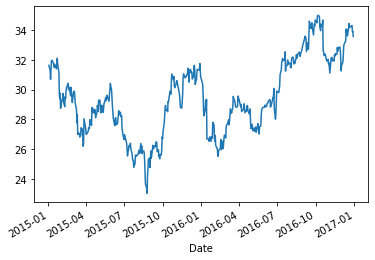

In [56]:
train_sample_df['Adj Close'].plot()

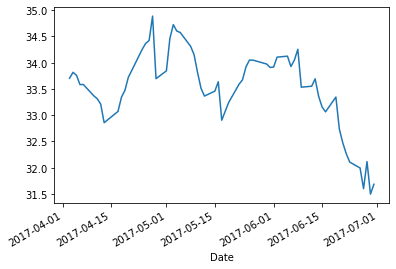

In [57]:
test_sample_df['Adj Close'].plot()

In [58]:
# 3단계 
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

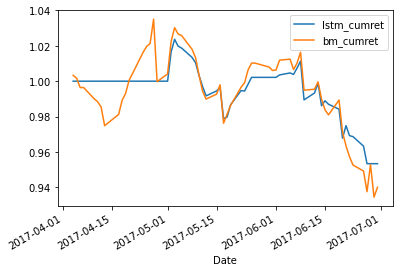

In [59]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

### Backtesting

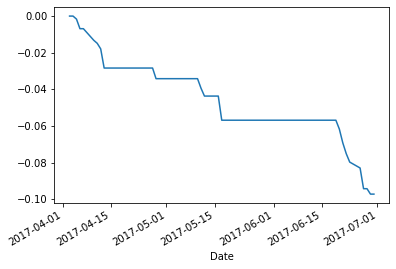

In [60]:
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

### LSTM st

In [61]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -21.92 %
Sharpe :  -1.62
VOL :  14.82 %
MDD :  9.73 %


### Buy and Hold

In [62]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -17.39 %
Sharpe :  -2.03
VOL :  9.37 %
MDD :  9.73 %
